# Week 6 - Imagery Alignment: Introduction and Simple Examples

Week 6 materials can be accessed [here](https://drive.google.com/drive/folders/1sO_vuclLGxr3iPsBRU09uPB2EJUkoCq_).

## 1. Introduction and Context

In remote sensing, aligning images from different sensors or different times is a critical step in many applications such as sea ice monitoring, land cover change, or multi-sensor data fusion. For instance, aligning a Sentinel-2 image to a Sentinel-3 image involves co-locating spatial points so that each pixel in one dataset corresponds to the same ground location (or sea/ice location) in the other dataset.

However, imagery alignment is often complicated by:
- Sensor differences (different resolutions, spectral bands, angles).  
- Scene dynamics (moving sea ice, vegetation changes, etc.).  
- Acquisition timing differences (the Earth or ice might move between acquisitions).

### 1.1 Three Methods for Image Alignment

1. **Auto-correlation (Cross-correlation)**  
   - A straightforward spatial-domain approach that searches for the shift (translation) maximizing the correlation between two images.  
   - Often implemented by brute-force correlation (rolling or shifting the image) or by using 2D convolution methods.

2. **Phase Correlation**  
   - A frequency-domain method leveraging the Fourier shift theorem.  
   - Typically faster for large images and can provide sub-pixel accuracy.  
   - Commonly used in remote sensing for global registration of two images that differ only by translation.

3. **ECC (Enhanced Correlation Coefficient)**  
   - An iterative, gradient-based approach (available in OpenCV’s `findTransformECC`) that maximizes a correlation measure between two images.  
   - Can be used for translation, affine, or homography alignment, but here we focus on translation mode.  
   - Often converges quickly and handles small or moderate shifts well.

In this Notebook, we will:
1. Introduce the basic concepts behind these three methods.  
2. Demonstrate them on simple, synthetic examples (e.g., 2D arrays or toy images).  
3. Lay groundwork for applying these methods to real satellite data in *Notebook 2*.



In [ ]:
!pip install pot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import ot
import cv2

%matplotlib inline

## Create synthetic images for example

This cell what we do is to create a synthetic pair of original image and shifted image so we can use them to illustrate the performance of the algorithm.

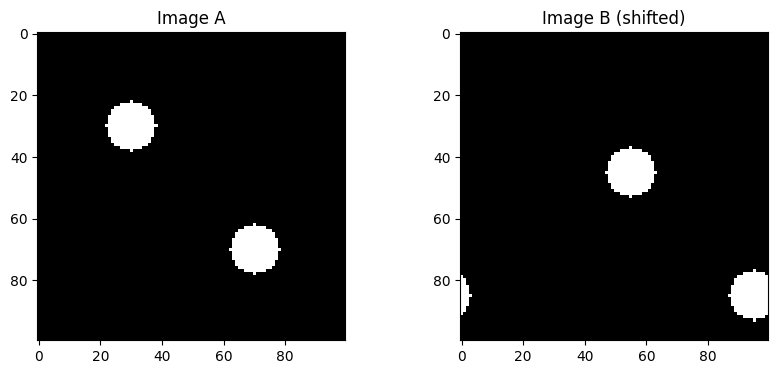

In [ ]:
def create_synthetic_image(size=(100, 100), centers=[(50, 50)], radius=10, intensity=1.0):
    """
    Create a synthetic image with circular bright spots.
    size: (height, width)
    centers: list of (row, col) circle centers
    radius: radius of circles
    intensity: pixel value inside the circle
    """
    img = np.zeros(size, dtype=np.float32)
    for c in centers:
        rr, cc = np.ogrid[:size[0], :size[1]]
        mask = (rr - c[0])**2 + (cc - c[1])**2 <= radius**2
        img[mask] = intensity
    return img

imageA = create_synthetic_image(
    size=(100, 100),
    centers=[(30, 30), (70, 70)],
    radius=8,
    intensity=1.0
)

#We can define a known shift, e.g., (dy, dx) = (5, 10)
known_shift = (15, 25)

def shift_image(img, shift):
    """
    Shift the image by (dy, dx) using np.roll for simplicity.
    This is a naive wrap-around shift, but it's enough to demonstrate the concept.
    """
    dy, dx = shift
    shifted = np.roll(img, dy, axis=0)
    shifted = np.roll(shifted, dx, axis=1)
    return shifted

imageB = shift_image(imageA, known_shift)

# We visualise them here
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(imageA, cmap='gray')
axes[0].set_title('Image A')
axes[1].imshow(imageB, cmap='gray')
axes[1].set_title('Image B (shifted)')
plt.show()


## Auto-correlation

Auto-correlation (or spatial cross-correlation) is a *direct* method to find the shift between two images by measuring how strongly one image correlates with various shifted versions of the other. Concretely, you can think of **“sliding”** one image over another in small increments and computing a correlation score at each step. The shift that maximizes this score is considered the best alignment.

- **Pros**: Easy to grasp conceptually, works well for moderate image sizes, and doesn’t require special libraries beyond basic 2D operations.
- **Cons**: Can be **slow** if you do a large brute-force search, and it only handles *pure translation* (no rotation or scaling).  



Known shift:        (26, 5)
Estimated shift (CC): (26, 5)


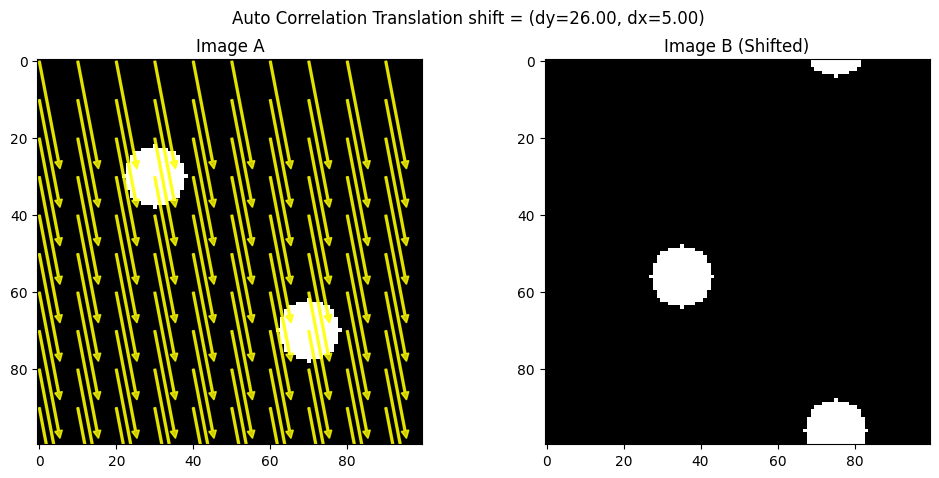

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
from scipy.signal import correlate2d

def find_shift_via_cross_correlation(imgA, imgB):
    """
    Compute the shift between imgA and imgB via cross-correlation.
    BUT then negate the result to match the (dy, dx) we used in np.roll(imageA, (dy, dx)).

    Returns (dy, dx) in the same sign convention as the 'shift_image' function.
    """
    corr = correlate2d(imgA, imgB, boundary='fill', mode='full')
    max_idx = np.unravel_index(np.argmax(corr), corr.shape)

    # By default, this returns how to move B-->A. We'll call those (shift_y, shift_x).
    shift_y = max_idx[0] - imgA.shape[0] + 1
    shift_x = max_idx[1] - imgA.shape[1] + 1

    # Negate them to get A-->B
    return (-shift_y, -shift_x)

def visualize_shift_arrows(imgA, imgB, shift, step=10, method_name="ECC"):
    (dy, dx) = shift

    fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Image A with arrows
    axA.imshow(imgA, cmap='gray')
    axA.set_title("Image A")

    h, w = imgA.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)

    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, dx, dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    # Plot Image B without arrows
    axB.imshow(imgB, cmap='gray')
    axB.set_title("Image B (Shifted)")

    plt.suptitle(f"{method_name} shift = (dy={dy:.2f}, dx={dx:.2f})")
    plt.show()

def create_synthetic_image(size=(100, 100), centers=[(30, 30), (70, 70)], radius=8, intensity=1.0):
    img = np.zeros(size, dtype=np.float32)
    rr, cc = np.ogrid[:size[0], :size[1]]
    for c in centers:
        mask = (rr - c[0])**2 + (cc - c[1])**2 <= radius**2
        img[mask] = intensity
    return img

def shift_image(img, shift):
    (dy, dx) = shift
    shifted = np.roll(img, dy, axis=0)
    shifted = np.roll(shifted, dx, axis=1)
    return shifted

# Create two synthetic images
imageA = create_synthetic_image()
known_shift = (26, 5)
imageB = shift_image(imageA, known_shift)

# Estimate shift (now it should match known_shift)
estimated_shift_cc = find_shift_via_cross_correlation(imageA, imageB)
print("Known shift:       ", known_shift)
print("Estimated shift (CC):", estimated_shift_cc)

# Visualize with arrows on a sampled grid
visualize_shift_arrows(imageA, imageB, estimated_shift_cc, step=10, method_name="Auto Correlation Translation")


## Phase Correlation

Phase correlation moves the cross-correlation problem into the **frequency domain**. By taking the Fourier transform of each image, multiplying one by the complex conjugate of the other, and looking at the **peak** in the inverse transform, you recover the shift. This leverages the **Fourier shift theorem**, which says that a translation in the spatial domain shows up as a **linear phase difference** in the frequency domain.

- **Pros**: Faster than brute-force auto-correlation (especially for large images), naturally yields subpixel accuracy, and is robust to certain intensity variations.
- **Cons**: Requires computing the Fourier transform; can become tricky if the images have major differences other than translation (e.g., rotation, scale changes).  


Known shift: (15, 10)
Estimated shift (Phase Corr): (15.0, 10.0)


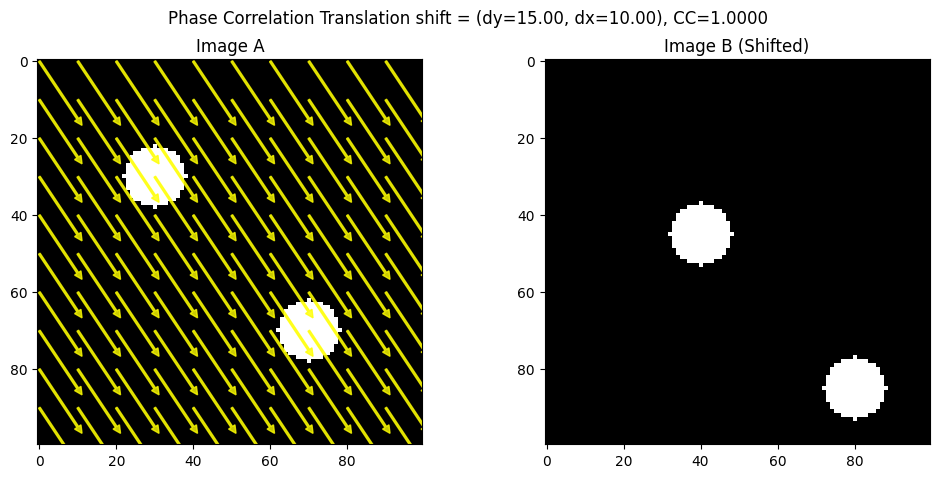

In [49]:
!pip install scikit-image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation
from matplotlib.patches import FancyArrow


def phase_corr_estimate_shift(imgA, imgB):
    """
    phase_cross_correlation(imgA, imgB) returns the shift that aligns B to A.
    If we want the shift that moves A to B (same sign as shift_image), we negate it.
    """
    shift, error, diffphase = phase_cross_correlation(imgA, imgB)
    # shift is (row_shift, col_shift) => let's rename (dyBtoA, dxBtoA)
    (dyBtoA, dxBtoA) = shift

    # We want the shift from A->B, so just negate:
    dyAtoB = -dyBtoA
    dxAtoB = -dxBtoA
    return (dyAtoB, dxAtoB)


def visualize_shift_arrows(imgA, imgB, shift, step=10, method_name="ECC"):
    (dy, dx) = shift

    fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Image A with arrows
    axA.imshow(imgA, cmap='gray')
    axA.set_title("Image A")

    h, w = imgA.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)

    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, dx, dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    # Plot Image B without arrows
    axB.imshow(imgB, cmap='gray')
    axB.set_title("Image B (Shifted)")

    plt.suptitle(f"{method_name} shift = (dy={dy:.2f}, dx={dx:.2f})")
    plt.show()


imageA = create_synthetic_image()

known_shift = (15, 10)

imageB = shift_image(imageA, known_shift)

estimated_shift_pc = phase_corr_estimate_shift(imageA, imageB)
print("Known shift:", known_shift)
print("Estimated shift (Phase Corr):", estimated_shift_pc)
visualize_shift_arrows(imageA, imageB, estimated_shift_pc, step=10, method_name="Phase Correlation Translation")



## ECC (Enhanced Correlation Coefficient) Alignment

## ECC (Enhanced Correlation Coefficient)

ECC is an *iterative* approach that tries to **maximize** a particular correlation measure between two images. It’s available in OpenCV’s `findTransformECC` function and can handle not only translation but also affine or homography transformations (if configured). For translation-only alignment, ECC updates the image transformation parameters step by step, converging to the shift that yields the highest correlation.

- **Pros**: Often more robust and *faster* than naive brute force; can yield subpixel accuracy; can be extended to more complex transformations if needed.
- **Cons**: Requires a decent initial guess for bigger shifts, and it’s more of a “black box” iterative method than a simple correlation map.  




Known shift: (5, 16)
Estimated shift (ECC): (4.9955096, 15.997296) CC: 0.999997673512336


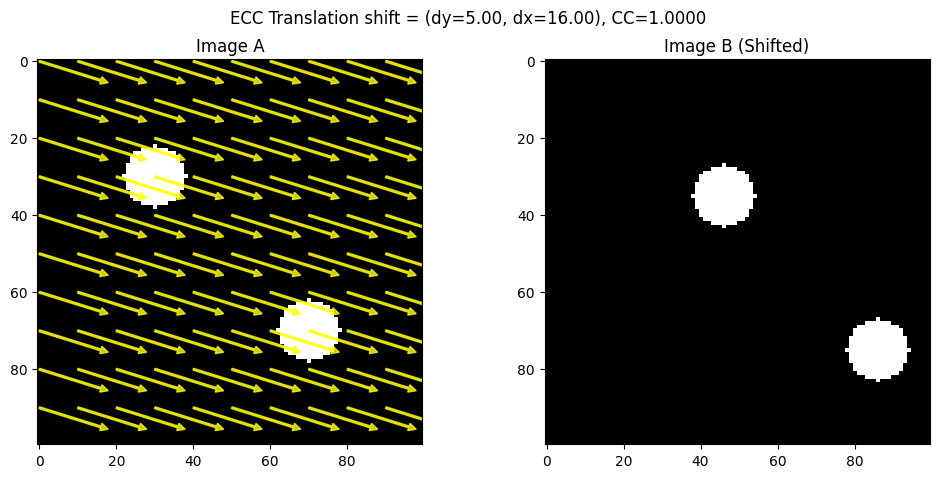

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

def align_ecc_translation(imgA, imgB, num_iterations=300, termination_eps=1e-6, gaussFiltSize=1):
    """
    Align imgB to imgA using ECC with a translation model.
    Handles large shifts by providing an initial guess.
    """
    imgA_f = imgA.astype(np.float32) / 255.0  # Normalize
    imgB_f = imgB.astype(np.float32) / 255.0  # Normalize

    warp_matrix = np.array([[1, 0, 10], [0, 1, 15]], dtype=np.float32)  # Initial guess for large shift

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, num_iterations, termination_eps)

    try:
        cc, warp_matrix = cv2.findTransformECC(
            templateImage=imgA_f,
            inputImage=imgB_f,
            warpMatrix=warp_matrix,
            motionType=cv2.MOTION_TRANSLATION,
            criteria=criteria
        )
        dx = warp_matrix[0, 2]
        dy = warp_matrix[1, 2]
        return (dy, dx), cc

    except cv2.error as e:
        print("ECC failed:", e)
        return (None, None), None  # Return None if ECC fails


def shift_image(img, shift):
    """
    Shift the image by (dy, dx) using np.roll.
    """
    dy, dx = shift
    shifted = np.roll(img, dy, axis=0)
    shifted = np.roll(shifted, dx, axis=1)
    return shifted


imageA = create_synthetic_image()
known_shift = (5, 16)

imageB = shift_image(imageA, known_shift)

ecc_shift, cc_value = align_ecc_translation(imageA, imageB)

print("Known shift:", known_shift)
print("Estimated shift (ECC):", ecc_shift, "CC:", cc_value)


def visualize_ecc_shift_arrows(imgA, imgB, shift, step=10, method_name="ECC"):
    (dy, dx) = shift

    fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Image A with arrows
    axA.imshow(imgA, cmap='gray')
    axA.set_title("Image A")

    h, w = imgA.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)

    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, dx, dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    # Plot Image B without arrows
    axB.imshow(imgB, cmap='gray')
    axB.set_title("Image B (Shifted)")

    plt.suptitle(f"{method_name} shift = (dy={dy:.2f}, dx={dx:.2f}), CC={cc_value:.4f}")
    plt.show()


# Example Usage
visualize_ecc_shift_arrows(imageA, imageB, ecc_shift, step=10, method_name="ECC Translation")



For ECC, we have also included an example on alignment on rotated images.

Known rotation: 30
Estimated shift and rotation (ECC): (31.691362, -18.300419, -29.994618645760085) CC: 0.9998342800636585


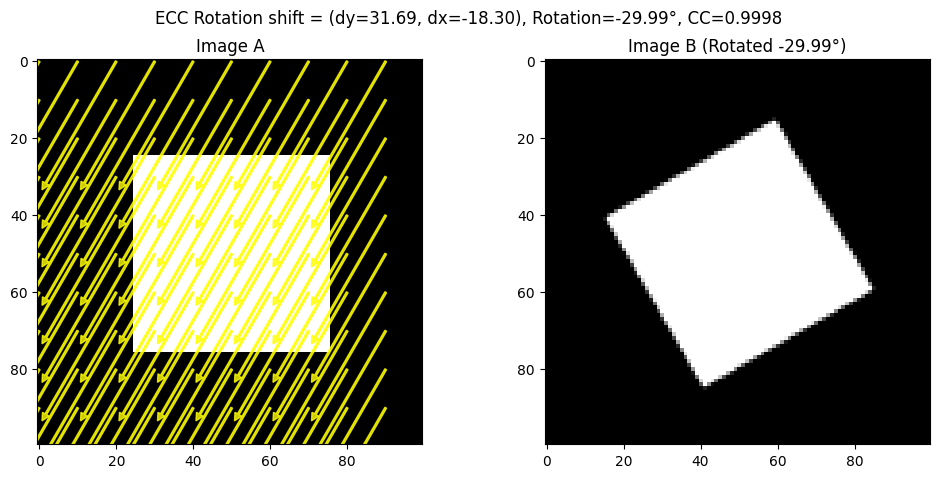

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

def create_synthetic_image(size=(100, 100), shape="rectangle"):
    """
    Creates a synthetic image with a simple geometric shape.
    """
    img = np.zeros(size, dtype=np.uint8)
    h, w = img.shape

    if shape == "rectangle":
        cv2.rectangle(img, (w//4, h//4), (3*w//4, 3*h//4), 255, -1)
    elif shape == "circle":
        cv2.circle(img, (w//2, h//2), w//4, 255, -1)

    return img


def rotate_image(img, angle, center=None):
    """
    Rotate the image around its center.
    """
    h, w = img.shape
    if center is None:
        center = (w//2, h//2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, rotation_matrix, (w, h))
    return rotated


def align_ecc_rotation(imgA, imgB, num_iterations=300, termination_eps=1e-6):
    """
    Align imgB to imgA using ECC with an Euclidean transformation model (rotation + translation).
    """
    imgA_f = imgA.astype(np.float32) / 255.0
    imgB_f = imgB.astype(np.float32) / 255.0

    warp_matrix = np.eye(2, 3, dtype=np.float32)  # Identity matrix for Euclidean transform

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, num_iterations, termination_eps)

    try:
        cc, warp_matrix = cv2.findTransformECC(
            templateImage=imgA_f,
            inputImage=imgB_f,
            warpMatrix=warp_matrix,
            motionType=cv2.MOTION_EUCLIDEAN,
            criteria=criteria
        )

        dx = warp_matrix[0, 2]
        dy = warp_matrix[1, 2]
        theta = np.arctan2(warp_matrix[1, 0], warp_matrix[0, 0]) * (180.0 / np.pi)

        return (dy, dx, theta), cc

    except cv2.error as e:
        print("ECC failed:", e)
        return (None, None, None), None


# Create Synthetic Image and Rotate
imageA = create_synthetic_image()
known_rotation = 30  # Degrees
imageB = rotate_image(imageA, known_rotation)

# Apply ECC Rotation Alignment
ecc_shift, cc_value = align_ecc_rotation(imageA, imageB)

print("Known rotation:", known_rotation)
print("Estimated shift and rotation (ECC):", ecc_shift, "CC:", cc_value)


def visualize_ecc_rotation_arrows(imgA, imgB, shift, step=10, method_name="ECC"):
    (dy, dx, theta) = shift

    fig, (axA, axB) = plt.subplots(1, 2, figsize=(12, 5))

    axA.imshow(imgA, cmap='gray')
    axA.set_title("Image A")

    h, w = imgA.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)

    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, dx, dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    axB.imshow(imgB, cmap='gray')
    axB.set_title(f"Image B (Rotated {theta:.2f}°)")

    plt.suptitle(f"{method_name} shift = (dy={dy:.2f}, dx={dx:.2f}), Rotation={theta:.2f}°, CC={cc_value:.4f}")
    plt.show()


# Visualize the Rotation Alignment
visualize_ecc_rotation_arrows(imageA, imageB, ecc_shift, step=10, method_name="ECC Rotation")